In [17]:
import pandas as pd
import numpy as np
import h3
import folium
from folium import Map, Marker, GeoJson
import json
from geojson.feature import *
import os
import sys
import shapely
import shapely.wkt
from shapely.geometry import Polygon
import geopandas as gpd
from folium import plugins
from folium.plugins import HeatMap
import vaex
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
sys.executable

'/Users/tobiasramm/anaconda3/envs/AAA_The_Dudes/bin/python'

## Constants

In [19]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


In [20]:
df_cleaned = vaex.open('./data/trips_prepared.hdf5')


df_cleaned.get_column_names()

['trip_id',
 'taxi_id',
 'trip_start_timestamp',
 'trip_end_timestamp',
 'trip_seconds',
 'trip_miles',
 'pickup_census_tract',
 'dropoff_census_tract',
 'pickup_community_area',
 'dropoff_community_area',
 'fare',
 'tips',
 'tolls',
 'extras',
 'trip_total',
 'payment_type',
 'company',
 'pickup_centroid_latitude',
 'pickup_centroid_longitude',
 'dropoff_centroid_latitude',
 'dropoff_centroid_longitude',
 'trip_start_hour',
 'trip_end_hour',
 'trip_start_4h_period',
 'trip_end_4h_period']

In [21]:
#n_samples = int(0.1 * len(df_cleaned))

# Randomly sample the dataframe
#df_cleaned = df_cleaned.sample(n=n_samples)

## Number of trips per cab.

In [22]:
num_trips = df_cleaned.groupby(by=['taxi_id'], agg=vaex.agg.count())

num_taxis = len(num_trips)
num_trips.rename('_count', 'count')
num_trips = num_trips.to_pandas_df()
num_trips = num_trips.sort_values('count', ascending=False)

cumulative_sum = num_trips['count'].cumsum()

total_rides = len(df_cleaned)
rides_90_percent = total_rides * 0.9
rides_75_percent = total_rides * 0.75
rides_50_percent = total_rides * 0.5

print(f"Of {num_taxis} Taxis and {total_rides} of rides:")
taxi_ids_90_percent = num_trips['count'][cumulative_sum <= rides_90_percent].count()
taxi_ids_75_percent = num_trips['count'][cumulative_sum <= rides_75_percent].count()
taxi_ids_50_percent = num_trips['count'][cumulative_sum <= rides_50_percent].count()

print(f"Num. of Taxis do 90% of the drives: {taxi_ids_90_percent}")
print(f"Num. of Taxis do 75% of the drives: {taxi_ids_75_percent}")
print(f"Num. of Taxis do 50% of the drives: {taxi_ids_50_percent}")

print("mean number of trips per taxi: ", num_trips['count'].mean())

Of 4686 Taxis and 10980710 of rides:
Num. of Taxis do 90% of the drives: 3311
Num. of Taxis do 75% of the drives: 2404
Num. of Taxis do 50% of the drives: 1350
mean number of trips per taxi:  2343.3013230900556


## Average total time and distance traveled by each cab

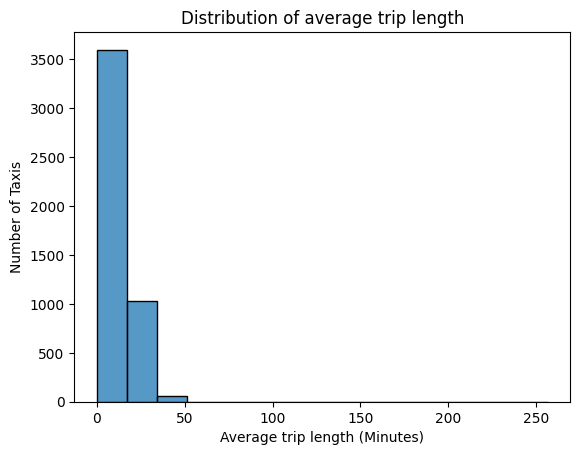

In [23]:
df_avg_trip_duration = df_cleaned.groupby('taxi_id', agg=vaex.agg.mean('trip_seconds'))

df_avg_trip_duration = df_avg_trip_duration.to_pandas_df()

df_avg_trip_duration['trip_seconds_mean'] = df_avg_trip_duration['trip_seconds_mean'] / 60

# Plot
sns.histplot(df_avg_trip_duration['trip_seconds_mean'], bins=15)
plt.title('Distribution of average trip length')
plt.xlabel('Average trip length (Minutes)')
plt.ylabel('Number of Taxis')
plt.show()

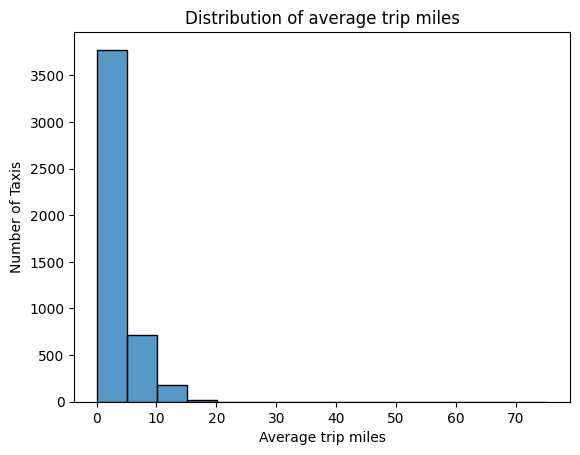

In [24]:
df_avg_trip_miles = df_cleaned.groupby('taxi_id', agg=vaex.agg.mean('trip_miles'))

df_avg_trip_miles = df_avg_trip_miles.to_pandas_df()

# Plot
sns.histplot(df_avg_trip_miles['trip_miles_mean'], bins=15)
plt.title('Distribution of average trip miles')
plt.xlabel('Average trip miles')
plt.ylabel('Number of Taxis')
plt.show()

## Trip Duration by Day of Week

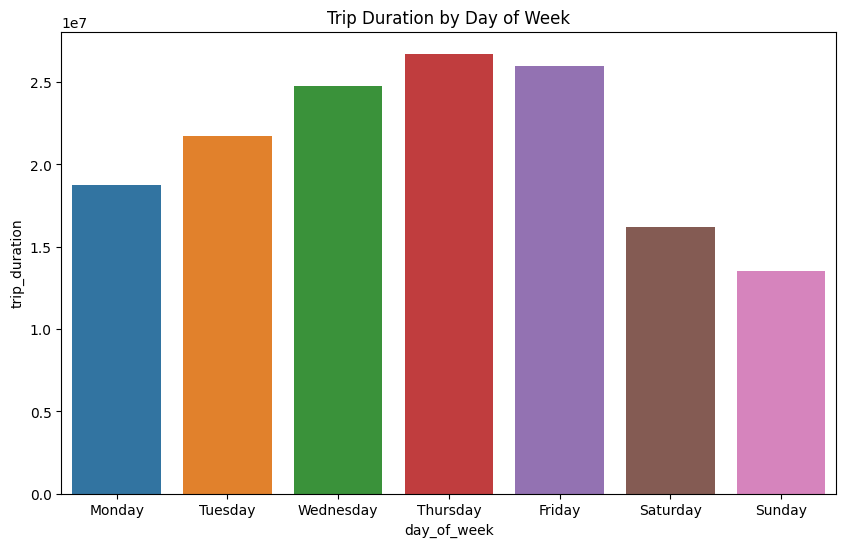

In [25]:
df = df_cleaned.to_pandas_df()

df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'])

df['trip_duration'] = df['trip_seconds'] / 60

df['day_of_week'] = df['trip_start_timestamp'].dt.day_name()
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days, ordered=True)

df_duration = df.groupby(['day_of_week'])['trip_duration'].sum().reset_index()
df_duration = df_duration.sort_values('day_of_week')


plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='trip_duration', data=df_duration)
plt.title('Trip Duration by Day of Week')
plt.show()

In [36]:

df = df_cleaned.copy()

# Fügen Sie eine Spalte für den Wochentag hinzu
df['start_hour_of_year'] = df['trip_start_timestamp'].dt.strftime("%m/%d/%Y - %H")
df_grouped = df.groupby('start_hour_of_year', agg={'count_taxis': vaex.agg.nunique('taxi_id')})
df_sorted = df_grouped.sort('start_hour_of_year')

all_hours = pd.date_range(start='1/1/2017', end='12/31/2017 23', freq='H')
all_hours_df = vaex.from_pandas(pd.DataFrame({'start_hour_of_year': all_hours, 'datetime':  all_hours}))

all_hours_df['start_hour_of_year'] = all_hours_df['start_hour_of_year'].dt.strftime("%m/%d/%Y - %H")

merged_df = all_hours_df.join(df_sorted, on='start_hour_of_year')
merged_df['count_taxis'] = merged_df['count_taxis'].fillna(0)


df_pd = merged_df.to_pandas_df()

unique_taxis_len = len(df_cleaned.taxi_id.unique())
df_pd['util'] = df_pd['count_taxis'] / unique_taxis_len  * 100
df_pd['available_taxis'] = unique_taxis_len - df_pd['count_taxis']


### Average Utilization for Weekdays

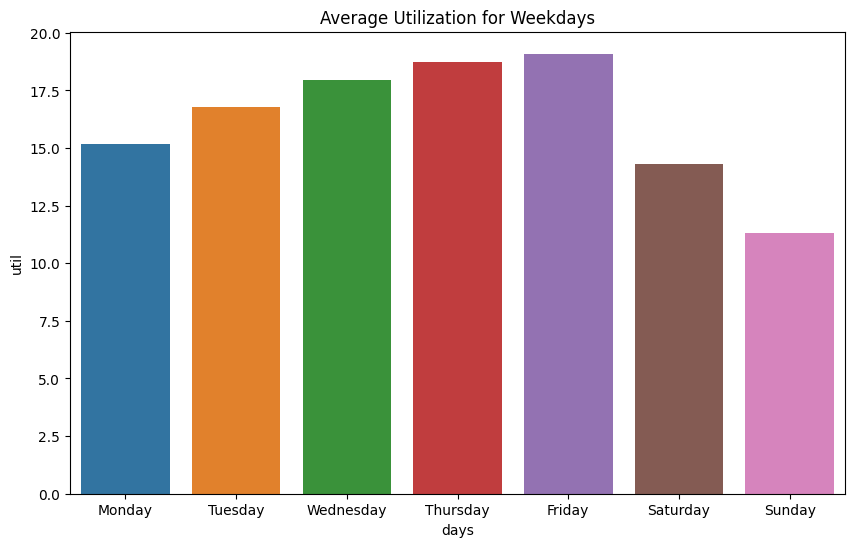

In [29]:
df_pd['days'] = df_pd['datetime'].dt.day_name()
df_pd['days'] = pd.Categorical(df_pd['days'], categories=days, ordered=True)

df_grouped = df_pd.groupby('days')['util'].mean().reset_index()

df_grouped = df_grouped.sort_values('days')


plt.figure(figsize=(10, 6))
sns.barplot(x='days', y='util', data=df_grouped)
plt.title('Average Utilization for Weekdays')
plt.show()


### Average Utilization for Hour of day

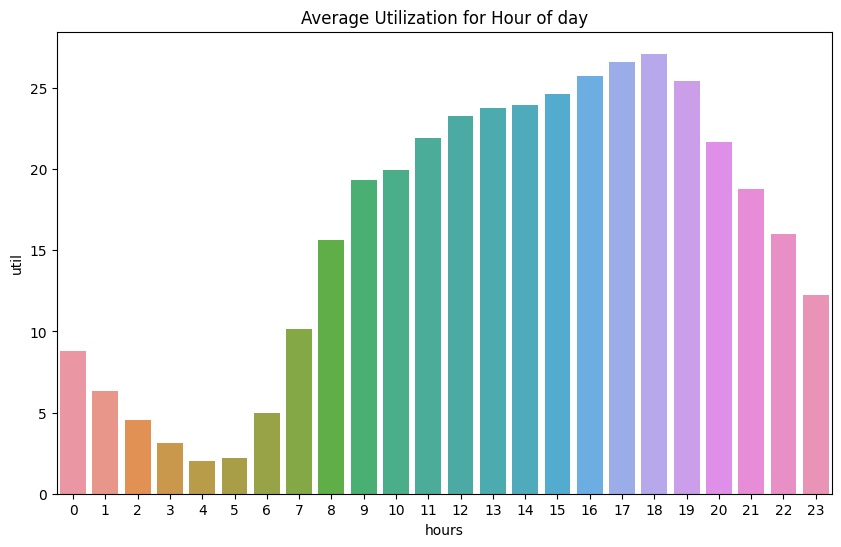

In [30]:
df_pd['hours'] = df_pd['datetime'].dt.hour

df_grouped = df_pd.groupby('hours')['util'].mean().reset_index()

df_grouped = df_grouped.sort_values('hours')


plt.figure(figsize=(10, 6))
sns.barplot(x='hours', y='util', data=df_grouped)
plt.title('Average Utilization for Hour of day')
plt.show()

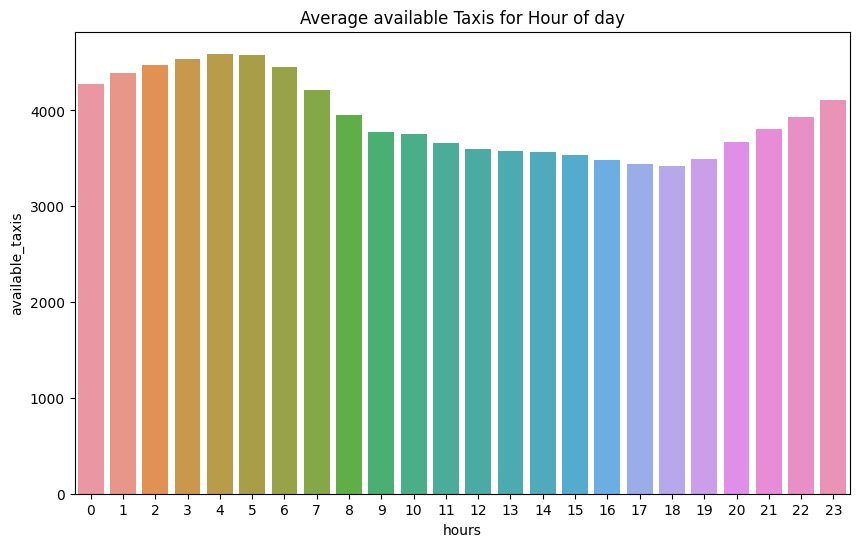

In [37]:
df_pd['hours'] = df_pd['datetime'].dt.hour

df_grouped = df_pd.groupby('hours')['available_taxis'].mean().reset_index()

df_grouped = df_grouped.sort_values('hours')


plt.figure(figsize=(10, 6))
sns.barplot(x='hours', y='available_taxis', data=df_grouped)
plt.title('Average available Taxis for Hour of day')
plt.show()

### Average Utilization plotted over year

<Axes: xlabel='datetime', ylabel='util'>

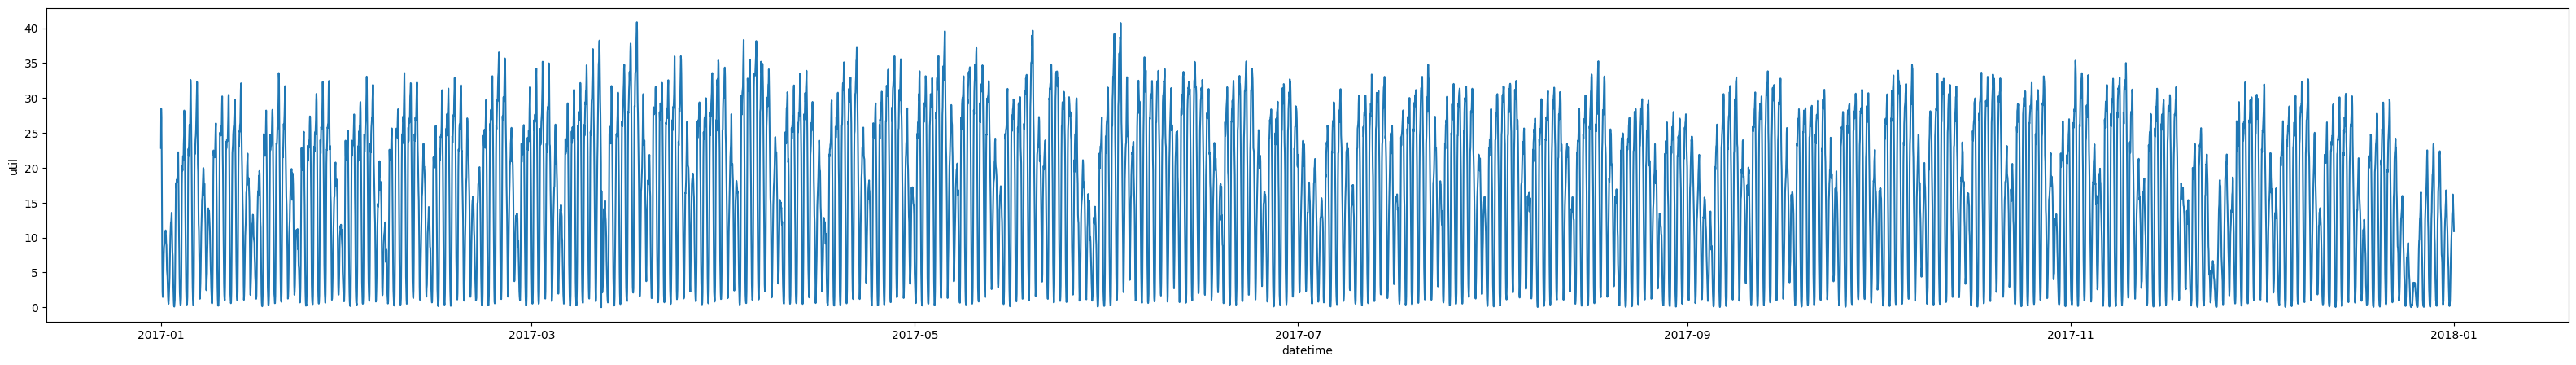

In [31]:

fig, ax = plt.subplots(figsize=(40, 5)) 

sns.lineplot(x="datetime", y="util",
             data=df_pd, ax=ax)